In [1]:
import pandas as pd
import requests, json, statistics
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Table of Contents

### 1. Importing Data

   ##### 1.1 Preprocessed Data
    
   ##### 1.2 Raw Data
    
    
### 2. Data Cleaning and Wrangling
    
    
### 3. Regression

   ##### 3.1 Creating Masks
    
   ##### 3.2 Feature Selection
    
   ##### 3.3 Prediction
    
   ##### 3.4 Adjustment


### 4. Saving the Dataset

---

# Importing Data

### Preprocessed Data

The file called "Covid-19 Dataset.csv" was created in another project. The making of this dataset is [here](https://github.com/ocaktans/Gathering-Covid-19-Data). The updated dataset is [here](https://www.kaggle.com/ocaktan/covid19pandemic-dataset).

In [2]:
df = pd.read_csv("Covid-19 Dataset.csv", parse_dates = ["Date"])

df.head()

,Country,Date,Confirmed,Recovered,Deaths,Active Cases,Death Rate(%),Increase,FirstDays,day_xth,Population_1k,TenCase,Cases/1000s
0,Afghanistan,2020-01-22,0,0,0,0,0.0,0.0,2020-02-24,0,38928,2020-03-11,0.0
1,Afghanistan,2020-01-23,0,0,0,0,0.0,0.0,2020-02-24,0,38928,2020-03-11,0.0
2,Afghanistan,2020-01-24,0,0,0,0,0.0,0.0,2020-02-24,0,38928,2020-03-11,0.0
3,Afghanistan,2020-01-25,0,0,0,0,0.0,0.0,2020-02-24,0,38928,2020-03-11,0.0
4,Afghanistan,2020-01-26,0,0,0,0,0.0,0.0,2020-02-24,0,38928,2020-03-11,0.0


In [3]:
df.dtypes

Country                  object
Date             datetime64[ns]
Confirmed                 int64
Recovered                 int64
Deaths                    int64
Active Cases              int64
Death Rate(%)           float64
Increase                float64
FirstDays                object
day_xth                   int64
Population_1k             int64
TenCase                  object
Cases/1000s             float64
dtype: object

### Raw Data from the Ministry of Health in Turkey

#### Web Scraping

In [4]:
url = "https://covid19.saglik.gov.tr/TR-66935/genel-koronavirus-tablosu.html#"
r = requests.get(url)
print(r.status_code)

200


In [5]:
soup = BeautifulSoup(r.content, "xml")

print(soup.title)

<title>
	Genel Koronavirüs Tablosu
</title>


In [6]:
script = soup.find_all("script")[16].text[26:-4]
data = json.loads(script)
turkeyfirst = pd.DataFrame.from_records(data)

# Data Cleaning and Wrangling

#### Filtering Turkey and Necessary Columns from the First Set

In [7]:
df = df[df["Country"] == "Turkey"][["Date","Confirmed", "Deaths", "Death Rate(%)","Increase","day_xth"]]

df.set_index("day_xth",inplace = True)

df = df[df["Date"] > "2020-03-10"]

In [8]:
df.head()

,Date,Confirmed,Deaths,Death Rate(%),Increase
day_xth,,,,,
0,2020-03-11,1,0,0.0,1.0
1,2020-03-12,1,0,0.0,0.0
2,2020-03-13,5,0,0.0,4.0
3,2020-03-14,5,0,0.0,0.0
4,2020-03-15,6,0,0.0,1.0


#### Cleaning Columns from the Second Dataset and Translation

In [51]:
turkey = turkeyfirst[['tarih', 'gunluk_test', 'gunluk_vaka', 'gunluk_hasta', 'gunluk_vefat',
        'gunluk_iyilesen', 'toplam_test', 'toplam_vefat', 'toplam_iyilesen', 'hastalarda_zaturre_oran', 
        'agir_hasta_sayisi','toplam_hasta']]

turkey.rename(columns = {'tarih': 'Date', 'gunluk_test': 'Inc_Test', 'gunluk_vaka':'Inc_Case','gunluk_hasta':'Inc_Patient', 
              'gunluk_vefat': 'Inc_Deaths', 'gunluk_iyilesen' : 'Inc_Recovered', 'toplam_test' : "Total_Tests", 
              'toplam_vefat':'Total_Deaths', 'toplam_iyilesen':'Total_Recovered', 'agir_hasta_sayisi':'Heavily_Ill',
              'toplam_hasta':'Total_Patient', 'hastalarda_zaturre_oran':'Pneumonia_Ratio'}, inplace = True)

turkey = turkey.reindex(columns = ['Date', 'Inc_Test', 'Inc_Case', 'Inc_Patient', 'Inc_Deaths',
        'Inc_Recovered', 'Total_Tests', 'Total_Patient', 'Total_Deaths','Total_Recovered', 
        'Heavily_Ill', 'Pneumonia_Ratio'])

#### Changing Types

In [10]:
turkey.dtypes

Date               object
Inc_Test           object
Inc_Case           object
Inc_Patient        object
Inc_Deaths         object
Inc_Recovered      object
Total_Tests        object
Total_Patient      object
Total_Deaths       object
Total_Recovered    object
Heavily_Ill        object
Pneumonia_Ratio    object
dtype: object

Inc_ indicates the daily increase in the related field.

In [11]:
turkey["Date"] = pd.to_datetime(turkey.Date, dayfirst = True)
turkey.sort_values(by=["Date"], inplace = True)
turkey = turkey.reset_index(drop=True)

In [12]:
turkey.head()

,Date,Inc_Test,Inc_Case,Inc_Patient,Inc_Deaths,Inc_Recovered,Total_Tests,Total_Patient,Total_Deaths,Total_Recovered,Heavily_Ill,Pneumonia_Ratio
0,2020-03-11,,,,,,,1,,,,
1,2020-03-12,,,,,,,1,,,,
2,2020-03-13,,,,,,,5,,,,
3,2020-03-14,,,,,,,6,,,,
4,2020-03-15,,,,,,,18,,,,


##### Masking Integer and Float columns

In [13]:
intcolumns = turkey.columns[1:-1]
floatcolumns = turkey.columns[-1:]

##### Cleaning of the Problematic Characters

In [14]:
turkey[intcolumns] = turkey[intcolumns].applymap(lambda x: x.replace('.', ''))
turkey[intcolumns] = turkey[intcolumns].replace("", 0, regex = True)
turkey[floatcolumns] = turkey[floatcolumns].replace("", 0, regex = True)
turkey[floatcolumns] = turkey[floatcolumns].replace(",", ".", regex = True)
turkey[floatcolumns] = turkey[floatcolumns].replace(" saat", "", regex = True)

In [15]:
turkey[intcolumns] = turkey[intcolumns].astype(int)
turkey[floatcolumns] = turkey[floatcolumns].astype(float)
turkey.dtypes

Date               datetime64[ns]
Inc_Test                    int32
Inc_Case                    int32
Inc_Patient                 int32
Inc_Deaths                  int32
Inc_Recovered               int32
Total_Tests                 int32
Total_Patient               int32
Total_Deaths                int32
Total_Recovered             int32
Heavily_Ill                 int32
Pneumonia_Ratio           float64
dtype: object

In [16]:
turkey.shape

(502, 12)

### Creating New Columns

The dataset called "turkey" already has the increase in deaths, yet it has some missing values. This column is created for comparison.

In [17]:
df["IncreaseDeath"] = df["Deaths"].diff().fillna(0).astype(int)
df["Increase"] = df["Increase"].astype(int)

Merging before adding more columns.

In [18]:
frame = df.merge(turkey, left_on="Date", right_on="Date")
frame.head()

,Date,Confirmed,Deaths,Death Rate(%),Increase,IncreaseDeath,Inc_Test,Inc_Case,Inc_Patient,Inc_Deaths,Inc_Recovered,Total_Tests,Total_Patient,Total_Deaths,Total_Recovered,Heavily_Ill,Pneumonia_Ratio
0,2020-03-11,1,0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0.0
1,2020-03-12,1,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
2,2020-03-13,5,0,0.0,4,0,0,0,0,0,0,0,5,0,0,0,0.0
3,2020-03-14,5,0,0.0,0,0,0,0,0,0,0,0,6,0,0,0,0.0
4,2020-03-15,6,0,0.0,1,0,0,0,0,0,0,0,18,0,0,0,0.0


Creating a column to check the differences of increase in deaths columns.

In [19]:
frame["Check"] = frame["IncreaseDeath"] - frame["Inc_Deaths"]
frame[frame["Check"] !=0]

,Date,Confirmed,Deaths,Death Rate(%),Increase,IncreaseDeath,Inc_Test,Inc_Case,Inc_Patient,Inc_Deaths,Inc_Recovered,Total_Tests,Total_Patient,Total_Deaths,Total_Recovered,Heavily_Ill,Pneumonia_Ratio,Check
6,2020-03-17,47,1,2.127660,29,1,0,0,0,0,0,0,98,1,0,0,0.0,1
8,2020-03-19,192,3,1.562500,94,2,0,0,0,0,0,0,359,4,0,0,0.0,2
9,2020-03-20,359,4,1.114206,167,1,0,0,0,0,0,0,670,9,0,0,0.0,1
10,2020-03-21,670,9,1.343284,311,5,0,0,0,0,0,0,947,21,0,0,0.0,5
11,2020-03-22,1236,30,2.427184,566,21,0,0,0,0,0,0,1236,30,0,0,0.0,21
12,2020-03-23,1529,37,2.419882,293,7,0,0,0,0,0,0,1529,37,0,0,0.0,7
13,2020-03-24,1872,44,2.350427,343,7,0,0,0,0,0,0,1872,44,0,0,0.0,7
14,2020-03-25,2433,59,2.424990,561,15,0,0,0,0,0,0,2433,59,0,0,0.0,15
15,2020-03-26,3629,75,2.066685,1196,16,0,0,0,0,0,0,3629,75,0,0,0.0,16
494,2021-07-18,5522039,50488,0.914300,0,0,233946,7680,0,66,5835,0,0,0,0,0,0.0,-66


It can be seen that there are some empty cells in the data from the ministry which caused the difference. Similar differences appear in total death columns as well. They do not affect our results.

#### Filling Empty Cells with One of the Preprocessed Columns

Empty cells in this column may affect our results. It is partially empty because the increase of the cases was being kept in "Inc_Patient" column until the 29th of July 2020. Yet "Increase" column is not fully correct either. Therefore, they must be combined to acquire an accurate column.

In [52]:
for cell in range(len(frame) - 1):
    
    if frame["Inc_Case"].loc[cell] == 0:
        
        frame["Inc_Case"].loc[cell] = frame["Increase"].loc[cell]
        
    else:
        
        frame["Inc_Case"].loc[cell] = frame["Inc_Case"].loc[cell]
        
pd.options.mode.chained_assignment = None

Columns "Increase" and "Inc_Patient" must differ after the 25th of November.

In [21]:
frame[frame["Date"] > "2020-11-24"].head()

,Date,Confirmed,Deaths,Death Rate(%),Increase,IncreaseDeath,Inc_Test,Inc_Case,Inc_Patient,Inc_Deaths,Inc_Recovered,Total_Tests,Total_Patient,Total_Deaths,Total_Recovered,Heavily_Ill,Pneumonia_Ratio,Check
259,2020-11-25,467730,12840,2.745173,6814,168,164547,28351,6814,168,3911,17733520,467730,12840,385480,4641,3.4,0
260,2020-11-26,503738,13014,2.583486,36008,174,168348,29132,6876,174,3291,17901868,474606,13014,388771,4711,3.4,0
261,2020-11-27,548244,13191,2.406045,44506,177,171113,29845,6592,177,3845,18072981,481198,13191,392616,4816,3.4,0
262,2020-11-28,578347,13373,2.312280,30103,182,174443,30103,6714,182,3611,18247424,487912,13373,396227,4903,3.4,0
263,2020-11-29,607628,13558,2.231299,29281,185,168212,29281,6439,185,4015,18415636,494351,13558,400242,5011,3.4,0


Difference between "Increase" and "Inc_Case" can be seen above. The correct one is "Inc_Case"

#### Increase of the deaths which is taken from 15 days later

This feature is created to be used in the model. It takes approximately 15 days to pass away after the first symptoms. We expect to find a stronger correlation by this method. Similar studies that inspired me were mentioned in the readme file.

In [22]:
frame["Death15"] = 0

for cell in range(len(frame)):
   
    if cell + 15 < (len(frame)):
        
        frame["Death15"].loc[cell] = frame["IncreaseDeath"].loc[cell + 15]
        
    else:
        
        break

Checking the code.

In [23]:
frame.tail(17)

,Date,Confirmed,Deaths,Death Rate(%),Increase,IncreaseDeath,Inc_Test,Inc_Case,Inc_Patient,Inc_Deaths,Inc_Recovered,Total_Tests,Total_Patient,Total_Deaths,Total_Recovered,Heavily_Ill,Pneumonia_Ratio,Check,Death15
484,2021-07-08,5465094,50096,0.916654,5171,48,226427,5171,0,48,5012,0,0,0,0,0,0.0,0,60
485,2021-07-09,5470764,50155,0.916782,5670,59,228826,5670,0,59,5126,0,0,0,0,0,0.0,0,58
486,2021-07-10,5476294,50192,0.916532,5530,37,224184,5530,0,37,5217,0,0,0,0,0,0.0,0,0
487,2021-07-11,5481555,50229,0.916328,5261,37,222068,5261,0,37,5242,0,0,0,0,0,0.0,0,0
488,2021-07-12,5486959,50278,0.916318,5404,49,227273,5404,0,49,5506,0,0,0,0,0,0.0,0,0
489,2021-07-13,5493244,50324,0.916107,6285,46,234439,6285,0,46,5162,0,0,0,0,0,0.0,0,0
490,2021-07-14,5500151,50367,0.915738,6907,43,238867,6907,0,43,5063,0,0,0,0,0,0.0,0,0
491,2021-07-15,5507455,50415,0.915396,7304,48,232257,7304,0,48,5103,0,0,0,0,0,0.0,0,0
492,2021-07-16,5514373,50450,0.914882,6918,35,229582,6918,0,35,5084,0,0,0,0,0,0.0,0,0
493,2021-07-17,5522039,50488,0.914300,7666,38,234161,7666,0,38,5490,0,0,0,0,0,0.0,0,0


Removing unnecessary columns.

In [24]:
frame = frame.drop(["Inc_Deaths","Total_Deaths","Total_Recovered","Check"], axis=1)

## Regression

In [25]:
frame.head()

,Date,Confirmed,Deaths,Death Rate(%),Increase,IncreaseDeath,Inc_Test,Inc_Case,Inc_Patient,Inc_Recovered,Total_Tests,Total_Patient,Heavily_Ill,Pneumonia_Ratio,Death15
0,2020-03-11,1,0,0.0,1,0,0,1,0,0,0,1,0,0.0,16
1,2020-03-12,1,0,0.0,0,0,0,0,0,0,0,1,0,0.0,17
2,2020-03-13,5,0,0.0,4,0,0,4,0,0,0,5,0,0.0,16
3,2020-03-14,5,0,0.0,0,0,0,0,0,0,0,6,0,0.0,23
4,2020-03-15,6,0,0.0,1,0,0,1,0,0,0,18,0,0.0,37


### Masks

We have to choose between the quantity of the features and our sample size since various cells are empty on certain dates. We do not have access to all attributes from day one.

"thegap" masks the days that we want to predict.

"masked0" simply includes outside of the gap. It will be used for merging purposes in the next sections.

"masked1" has a bigger size than "masked2", yet we have to exclude some columns(deleted columns are partially empty for these dates).

"masked2" has more features with less size.

In [26]:
thegap = frame[(frame["Date"] > "2020-07-28") & (frame["Date"] < "2020-11-25")].copy()

masked0 = frame[(frame["Date"] <= "2020-07-28") | (frame["Date"] >= "2020-11-25")].copy()

masked1 = frame[((frame["Date"] <= "2020-07-28") | (frame["Date"] >= "2020-11-25") & (frame["Death15"] != 0))].copy().drop(["Pneumonia_Ratio", 
                                                                                                "Heavily_Ill", "Inc_Patient",
                                                                                               "Total_Patient"], axis=1)
masked1 = masked1[masked1["Inc_Test"] != 0]

masked2 = frame[(frame["Date"] >= "2020-11-25") & (frame["Death15"] != 0)].copy()

In [27]:
masked1.head(5)

,Date,Confirmed,Deaths,Death Rate(%),Increase,IncreaseDeath,Inc_Test,Inc_Case,Inc_Recovered,Total_Tests,Death15
16,2020-03-27,5698,92,1.614602,2069,17,7533,2069,0,47823,95
17,2020-03-28,7402,108,1.459065,1704,16,7641,1704,0,55464,97
18,2020-03-29,9217,131,1.421287,1815,23,9982,1815,0,65446,98
19,2020-03-30,10827,168,1.551676,1610,37,11535,1610,0,76981,107
20,2020-03-31,13531,214,1.581553,2704,46,15422,2704,0,92403,115


### Feature Selection

I have realized that correlation is a better way to explore relations for this dataset rather than mutual information. Therefore, correlation scores are used as indicators of the relations.

<AxesSubplot:>

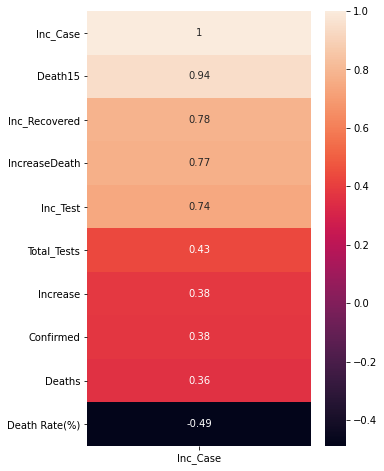

In [28]:
plt.figure(figsize=(5, 8))
sns.heatmap(masked1.corr()[["Inc_Case"]].sort_values(by = "Inc_Case", ascending = False), annot = True)

#### Correlations with p-values

P.S. This could be done with SelectKBest as well.

In [29]:
corlist = []

X = masked1.loc[:,masked1.columns != "Inc_Case"]
X = X.loc[:,X.columns != "Date"]
y = masked1.loc[:,"Inc_Case"]

for col in X.columns:
    
    cor = pearsonr(X[col], y)
    corlist.append([col, cor[0], cor[1]])

cordf = pd.DataFrame(corlist, columns = ["Features", "Correlation", "p-value"])
cordf.sort_values(by = "p-value", inplace = True)
cordf

,Features,Correlation,p-value
8,Death15,0.944697,1.426711e-170
6,Inc_Recovered,0.780237,6.621538e-73
4,IncreaseDeath,0.769935,7.081351e-70
5,Inc_Test,0.742794,1.332649e-62
2,Death Rate(%),-0.488498,2.166575e-22
7,Total_Tests,0.432317,2.264611e-17
3,Increase,0.381599,1.411580e-13
0,Confirmed,0.376866,2.963298e-13
1,Deaths,0.356948,5.900969e-12


In [30]:
corlist2 = []

X2 = masked2.loc[:,masked2.columns != "Inc_Case"]
X2 = X2.loc[:,X2.columns != "Date"]
y2 = masked2.loc[:,"Inc_Case"]

for col in X2.columns:
    
    cor2 = pearsonr(X2[col], y2)
    corlist2.append([col, cor2[0], cor2[1]])

cordf2 = pd.DataFrame(corlist2, columns = ["Features", "Correlation", "p-value"])
cordf2.sort_values(by = "p-value", inplace = True)
cordf2

,Features,Correlation,p-value
12,Death15,0.942844,7.046901e-109
7,Inc_Recovered,0.700697,1.080126e-34
5,Inc_Test,0.672835,3.774186e-31
4,IncreaseDeath,0.670029,8.171895e-31
6,Inc_Patient,0.585231,3.631292e-22
10,Heavily_Ill,0.524470,2.264266e-17
3,Increase,0.323912,6.447709e-07
1,Deaths,-0.212989,1.276462e-03
11,Pneumonia_Ratio,-0.168765,1.104456e-02
0,Confirmed,-0.128352,5.400057e-02


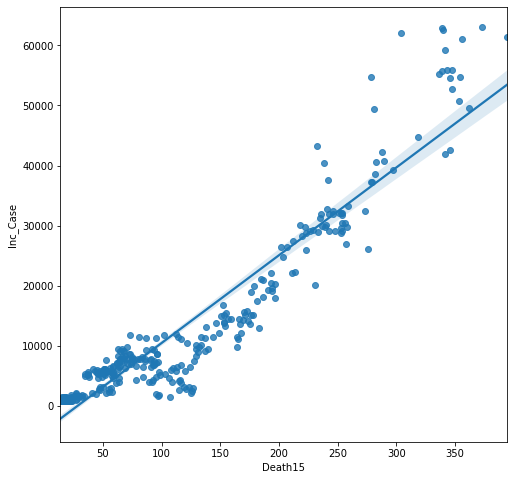

In [31]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x="Death15", y="Inc_Case", data=masked1)

##### Same feature as a quadratic equation

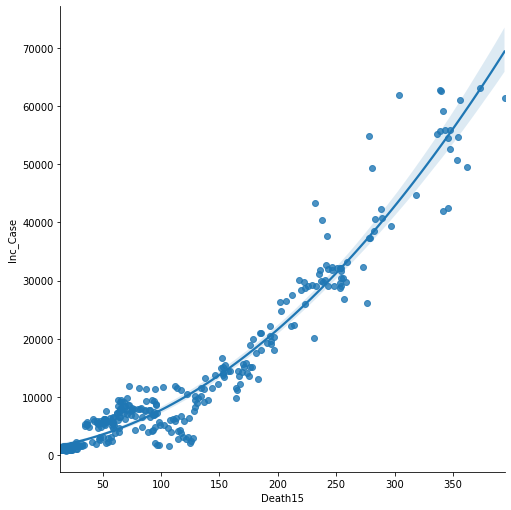

In [32]:
sns.lmplot(x = "Death15", y = "Inc_Case", data = masked1, order=2, height = 7)

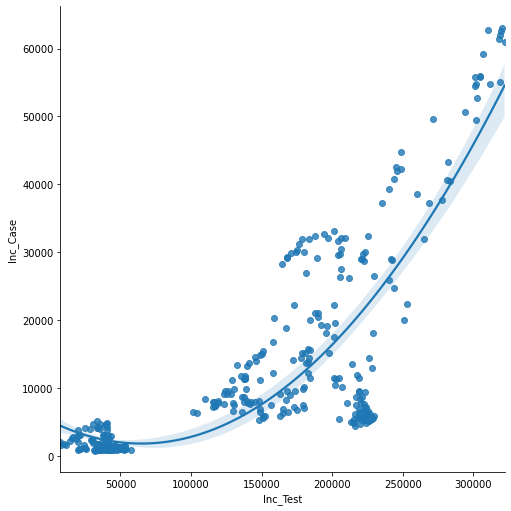

In [33]:
sns.lmplot(x = "Inc_Test", y = "Inc_Case", data = masked1, order=2, height = 7)

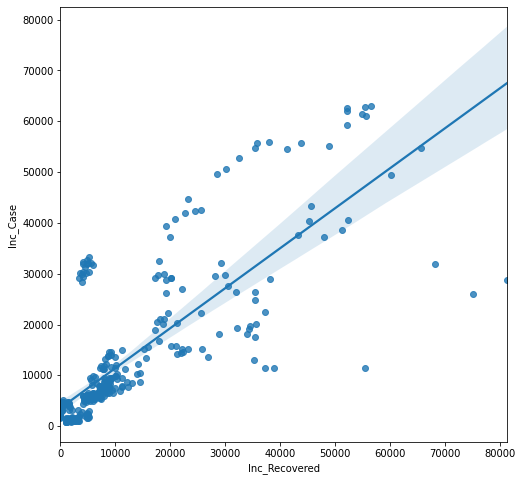

In [34]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x="Inc_Recovered", y="Inc_Case", data=masked1)

#### Accuracy of the Model

cross_val_score method does not work well with this dataset(especially in the first folds) since it is ordered by time. As an alternative, multiple train test split methods are used and the average scores are recorded. 

The code below has the best features and the best degree of these features(even though "Inc_Recovered" seems like it might be a linear equation, it works better as a polynomial) that I found. Feel free to change the variables to test it yourself. 

Note that cumulative values of the predictions were considered as a method to measure accuracy as well since we know the total case values in the gap from official sources. For example the 3rd order of the features resulted in a slightly higher accuracy while the cumulative value of the cases was closer to the actual value in the second order.

In [35]:
X = masked1[["Death15", "Inc_Test", "Inc_Recovered"]]

y = masked1[["Inc_Case"]]

PolyReg = LinearRegression()

polynom = PolynomialFeatures(degree = 2) 

scores = []

for i in range(10):
    
    X_train, X_test, y_train, y_test = train_test_split(polynom.fit_transform(X), y, test_size=0.2, random_state=i)
    
    PolyReg.fit(X_train, y_train)

    scores.append(PolyReg.score(X_test, y_test))
    
statistics.mean(scores)

0.9687649407389912

### Prediction 

In [36]:
PolyReg.fit(polynom.fit_transform(X), y)

thegap["Estimated"] = PolyReg.predict(polynom.fit_transform(thegap[["Death15", "Inc_Test", "Inc_Recovered"]]))

Sum of the estimations is supposed to be equal to 1,159,626

In [37]:
thegap.Estimated.sum()

998295.7797111243

In percentage

In [38]:
(thegap.Estimated.sum()*100)/1159626

86.08773688336794

#### Visualization

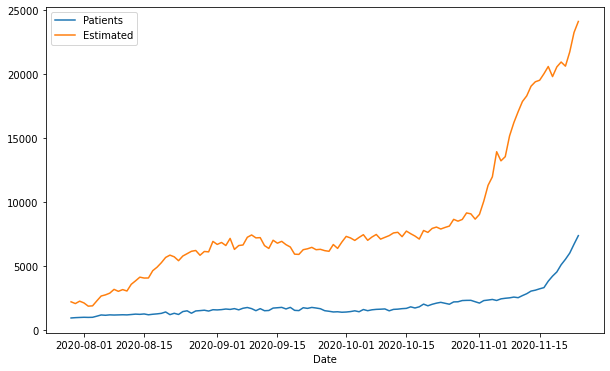

In [39]:
plt.figure(figsize = [10,6])
plt.plot(thegap["Date"],thegap["Inc_Case"], label = "Patients")
plt.plot(thegap["Date"],thegap["Estimated"], label = "Estimated")
plt.xlabel("Date")
plt.legend()
plt.show()

#### Merging the Datasets 

In [40]:
masked0["Estimated"] = None

In [41]:
final = masked0.append(thegap, ignore_index = True)
final.sort_values(by=["Date"], inplace = True)
final = final.reset_index(drop=True)

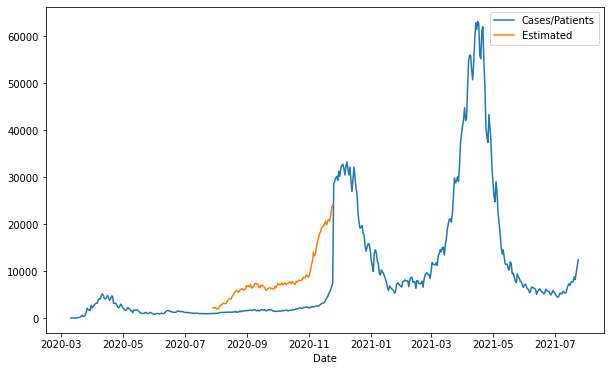

In [42]:
plt.figure(figsize = [10,6])
plt.plot(final["Date"],final["Inc_Case"], label = "Cases/Patients")
plt.plot(final["Date"],final["Estimated"], label = "Estimated")
plt.xlabel("Date")
plt.legend()
plt.show()

### Adjustment 

Since we have the total number of cases, we can distribute them to each day as if our estimations were coefficients.

In [43]:
for i in range(len(final) - 1):
    
    if final["Estimated"].loc[i] != None:
    
        final["Adjusted"] = (1159626*final["Estimated"])/(final["Estimated"].sum())
    
    else:
    
        final["Adjusted"] = None

Sum of the adjusted column should be equal to 1,159,626 if the code above is correct.

In [44]:
final.Adjusted.sum()

1159626.0

These values should be integers.

In [45]:
final["Estimated"] = final["Estimated"].round()
final["Adjusted"] = final["Adjusted"].round()

#### Filtering for a Closer Look with the Visualization 

These dates mean nothing important. They are just there for scaling purposes.

In [46]:
thegap = final[(final["Date"] > "2020-07-14") & (final["Date"] < "2020-12-09")].copy()

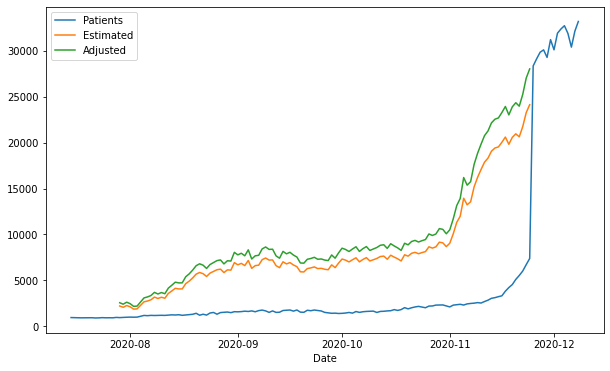

In [47]:
plt.figure(figsize = [10,6])
plt.plot(thegap["Date"],thegap["Inc_Case"], label = "Patients")
plt.plot(thegap["Date"],thegap["Estimated"], label = "Estimated")
plt.plot(thegap["Date"],thegap["Adjusted"], label = "Adjusted")
plt.xlabel("Date")
plt.legend()
plt.show()

# Saving the Dataset

In [48]:
final = final.drop(["Increase", "Inc_Patient", "Total_Patient", "Heavily_Ill", "Pneumonia_Ratio"], axis=1)

In [49]:
final.to_csv("TurkeyAdjusted.csv", index = False)

In [50]:
final.tail()

,Date,Confirmed,Deaths,Death Rate(%),IncreaseDeath,Inc_Test,Inc_Case,Inc_Recovered,Total_Tests,Death15,Estimated,Adjusted
496,2021-07-20,5546166,50650,0.913243,46,198537,8780,4561,0,0,NaN,NaN
497,2021-07-21,5554317,50709,0.912966,59,184462,8151,4946,0,0,NaN,NaN
498,2021-07-22,5563903,50761,0.912327,52,214196,9586,5093,0,0,NaN,NaN
499,2021-07-23,5574997,50821,0.911588,60,219528,11094,5215,0,0,NaN,NaN
500,2021-07-24,5587378,50879,0.910606,58,221463,12381,5383,0,0,NaN,NaN
